In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -s /content/drive/MyDrive /mygdrive

In [ ]:
!ls /mygdrive

 Annotations1024.tar   test.zip		       Vehicules1024.tar.003
'Colab Notebooks'      train.zip	       Vehicules1024.tar.004
 CS2		       Vehicules1024.tar.001   Vehicules1024.tar.005
 cv.zip		       Vehicules1024.tar.002


In [1]:
import math
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
import sys
import PIL
from PIL import Image
import shapely
from shapely.geometry import Polygon
import shutil
import random
from collections import Counter
import sys
from shapely import speedups
speedups.disable()
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab.patches import cv2_imshow

In [ ]:
shapely.__version__, PIL.__version__, cv2.__version__

('1.7.1', '7.1.2', '4.1.2')

In [ ]:
len(os.listdir("./Vehicules1024")), len(os.listdir("./Annotations1024"))

(2538, 1272)

# Below images are corrupted

In [ ]:
os.remove("./Vehicules1024/00000935_co.png")
os.remove("./Vehicules1024/00001233_co.png")
os.remove("./Vehicules1024/00000305_co.png")
os.remove("./Vehicules1024/00000615_co.png")
os.remove("./Vehicules1024/00001271_ir.png")

In [ ]:
for image in os.listdir("./Vehicules1024/"):
  if image.endswith("_ir.png"):
    os.remove("./Vehicules1024/" + image)

In [ ]:
def plot_distribution(classes, name):
    counter = Counter(classes)
    print(name, counter)
    print(sorted(counter.keys()), len(counter.keys()))
    plt.figure()
    plt.bar(counter.keys(), counter.values())
    plt.xlabel("Class")
    plt.ylabel("Objects points per class")
    plt.title("Distribution of classes in " + str(name))

In [ ]:
def know_data_(path, annot_path):
  percentage_area = []
  classes = []
  for image in os.listdir(path):
    if image.endswith("_co.png"):
      im = cv2.imread(path + image)
      h, w, _ = im.shape
      annot_name = image.replace("_co.png", ".txt")
      if not os.path.exists(annot_path + annot_name):
        continue
      annotations = pd.read_csv(annot_path + annot_name, sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
      annotations["w"] = annotations[["x1", "x2", "x3", "x4"]].max(axis = 1) - annotations[["x1", "x2", "x3", "x4"]].min(axis = 1)
      annotations["h"] = annotations[["y1", "y2", "y3", "y4"]].max(axis = 1) - annotations[["y1", "y2", "y3", "y4"]].min(axis = 1)
      annotations["percentage"] = 100 * ( annotations["w"] * annotations["h"] ) / ( w * h )
      percentage_area.extend(annotations["percentage"].tolist())
      classes.extend(annotations["class"].tolist())
  return percentage_area, classes


In [ ]:
area, classes = know_data_("./Vehicules1024/", "./Annotations1024/")

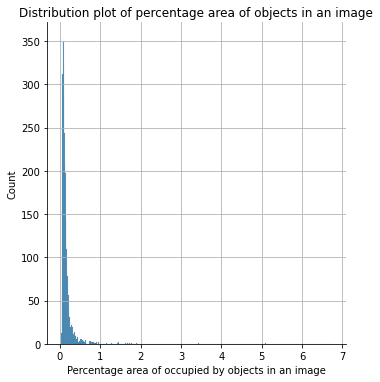

In [ ]:
sns.displot(x = area)
plt.xlabel("Percentage area of occupied by objects in an image")
plt.title("Distribution plot of percentage area of objects in an image")
plt.grid()
plt.show()

In [ ]:
np.percentile(np.array(area), 1)

nan

In [ ]:
s = pd.Series(area)
s.quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

0.10    0.064087
0.20    0.076103
0.30    0.086117
0.40    0.097713
0.50    0.110149
0.60    0.126457
0.70    0.146866
0.80    0.178375
0.90    0.250206
0.99    0.913994
dtype: float64

* From above, we can see that 99.9% of the objects occupy area less than 1% in the entire image. 90% of the objects occupy area less than or equal to 0.25% in the entire image.

dataset Counter({1: 1399, 11: 950, 5: 395, 2: 304, 10: 204, 4: 188, 23: 170, 9: 101, 31: 48, 7: 4, 8: 3})
[1, 2, 4, 5, 7, 8, 9, 10, 11, 23, 31] 11


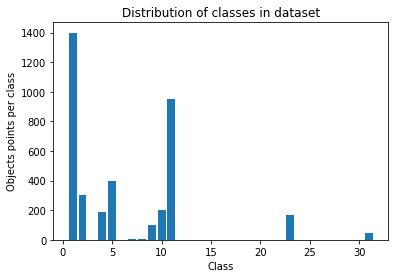

In [ ]:
plot_distribution(classes, "dataset")

In [ ]:
def print_files(path, annot_path, classes):
  for image in os.listdir(path):
    if image.endswith("_co.png"):
      im = cv2.imread(path + image)
      h, w, _ = im.shape
      annot_name = image.replace("_co.png", ".txt")
      if not os.path.exists(annot_path + annot_name):
        continue
      annotations = pd.read_csv(annot_path + annot_name, sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
      for index, row in annotations.iterrows():
        for c in classes:
          if int(row["class"]) == c:
            print(c, annot_name)
  

In [ ]:
print_files("./Vehicules1024/", "./Annotations1024/", [7, 8])

8 00000839.txt
7 00000581.txt
8 00000549.txt
8 00000165.txt
7 00000364.txt
7 00000824.txt
7 00000327.txt


In [ ]:
def make_datasets(src1, src2, dstn, sample = None):
  '''
  This function makes datasets.
  If sample is None, then all the files from src1 and src2 are moved to dstn
  else a sample of them is moved from src1, src2 to dstn 
  '''
  files = os.listdir(src1)
  if sample is None:
    for file in files:
      f2 = file.replace("_co.png", ".txt")
      if os.path.exists(src2 + f2):
        shutil.move(src1 + file, dstn + f2.replace(".txt", ".png"))
        shutil.move(src2 + f2, dstn + f2)
  else:
    for n in sample:
      f2 = files[n].replace("_co.png", ".txt")
      if os.path.exists(src2 + f2): 
        shutil.move(src1 + files[n], dstn + f2.replace(".txt", ".png"))
        shutil.move(src2 + f2, dstn + f2)


# train test cv split of data

In [ ]:
!mkdir "test"
!mkdir "cv"
!mkdir "train"

In [ ]:
np.random.seed(10)

# test
test_sample = random.sample(range(len(os.listdir("./Vehicules1024/"))), int(0.2 * len(os.listdir("./Vehicules1024/"))))
make_datasets("./Vehicules1024/", "./Annotations1024/", "./test/", test_sample)

# cv
cv_sample = random.sample(range(len(os.listdir("./Vehicules1024/"))), int(0.25 * len(os.listdir("./Vehicules1024/"))))
make_datasets("./Vehicules1024/", "./Annotations1024/", "./cv/", cv_sample)

# train
make_datasets("./Vehicules1024/",  ".Annotations1024/", "./train/")

len(os.listdir("./train")), len(os.listdir("./cv")), len(os.listdir("./test"))

(1510, 492, 490)

2.0
5.0
5.0
2.0
1.0
5.0
5.0
11.0
1.0
5.0
5.0
1.0
1.0
5.0


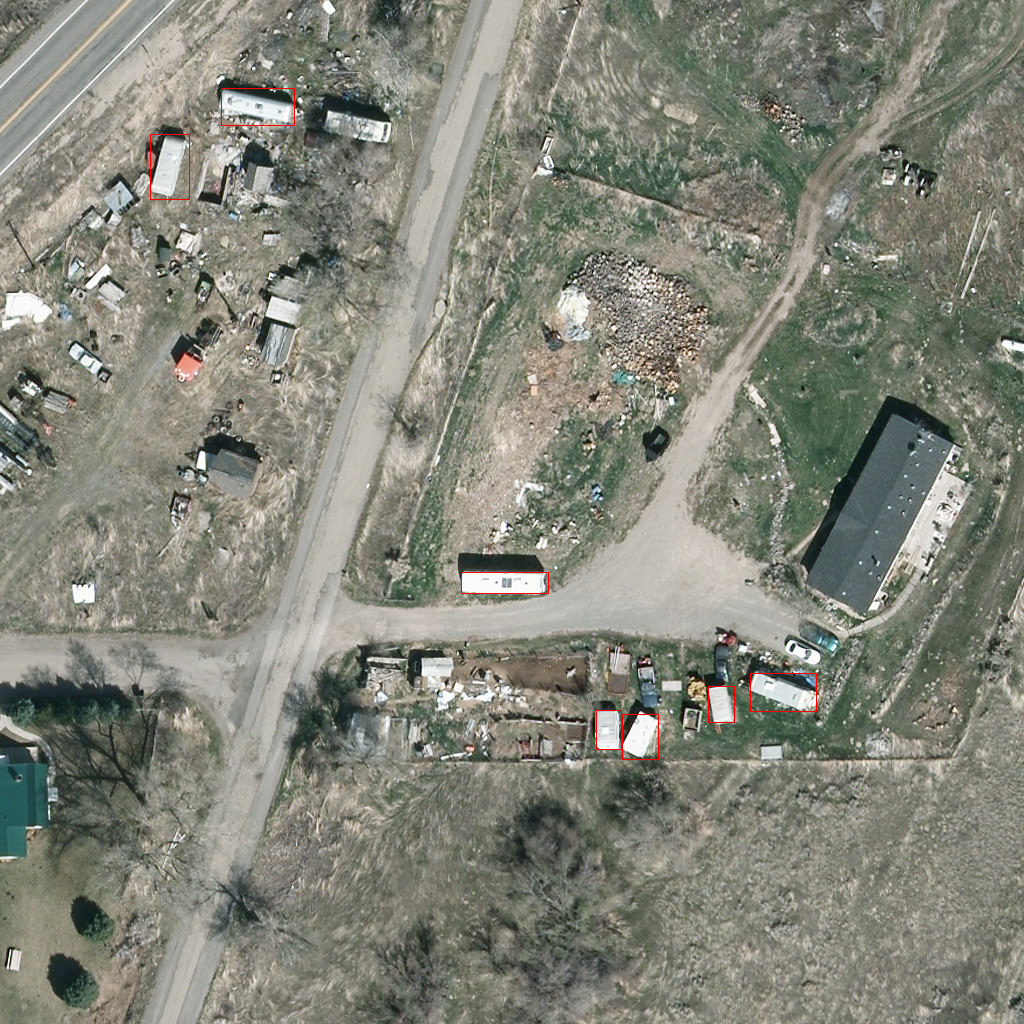

In [ ]:
name = "00000004"

img_path = "./train/" + name + ".png"
annot_path = "./train/" + name + ".txt"
img = cv2.imread(img_path)

df = pd.read_csv(annot_path, sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
for index, row in df.iterrows():
  x1 = int(row["x1"])
  x2 = int(row["x2"])
  x3 = int(row["x3"])
  x4 = int(row["x4"])
  y1 = int(row["y1"])
  y2 = int(row["y2"])
  y3 = int(row["y3"])
  y4 = int(row["y4"])
  cv2.rectangle(img, (min(x1, x2, x3, x4), min(y1, y2, y3, y4)), (max(x1, x2, x3, x4), max(y1, y2, y3, y4)), (0,0,255), 2)

cv2.imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# distribution of classes

In [ ]:
'''
original class: 7 - motorcycle and 8 -bus has 3 and 4 objects respectively in total. So, removing them 
'''

'''
car-1
truck-2
plane-3
tractor-4
camping_car-5
boat-6
pickup-7
other-8
van-9
'''

def know_data(path):
  classes = []
  for image in os.listdir(path):
    if image.endswith(".png"):
      im = cv2.imread(path + image)
      h, w, _ = im.shape
      annot_name = image.replace(image.split(".")[-1], "txt")
      annotations = pd.read_csv(path + annot_name, sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
      annotations = annotations[annotations["class"].isin([1,2,4,5,9,10,11,23,31])]
      annotations["class"].replace(31, 3, inplace = True)
      annotations["class"].replace(23, 6, inplace = True)
      annotations["class"].replace(11, 7, inplace = True)
      annotations["class"].replace(10, 8, inplace = True)
      annotations["w"] = annotations[["x1", "x2", "x3", "x4"]].max(axis = 1) - annotations[["x1", "x2", "x3", "x4"]].min(axis = 1)
      annotations["h"] = annotations[["y1", "y2", "y3", "y4"]].max(axis = 1) - annotations[["y1", "y2", "y3", "y4"]].min(axis = 1)
      classes.extend(annotations["class"].tolist())
  return classes

In [ ]:
train_classes = know_data("./train/")
cv_classes = know_data("./cv/")
test_classes = know_data("./test/")

train set Counter({1: 780, 7: 562, 5: 239, 2: 192, 8: 145, 4: 126, 6: 107, 9: 61, 3: 22})
[1, 2, 3, 4, 5, 6, 7, 8, 9] 9
cv set Counter({1: 313, 7: 195, 5: 81, 2: 62, 4: 30, 8: 30, 6: 27, 9: 19, 3: 11})
[1, 2, 3, 4, 5, 6, 7, 8, 9] 9
test set Counter({1: 306, 7: 193, 5: 75, 2: 50, 6: 36, 4: 32, 8: 29, 9: 21, 3: 15})
[1, 2, 3, 4, 5, 6, 7, 8, 9] 9


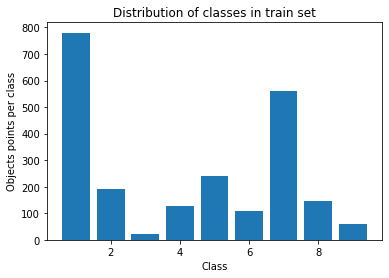

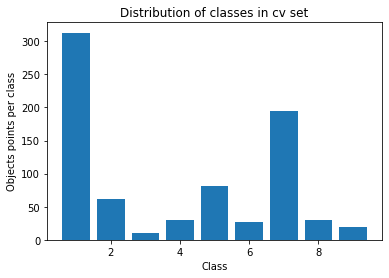

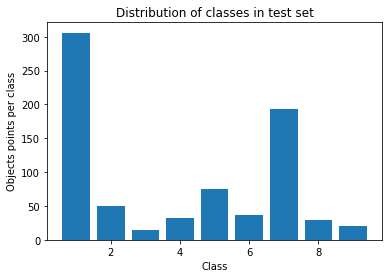

In [ ]:
plot_distribution(train_classes, "train set")
plot_distribution(cv_classes, "cv set")
plot_distribution(test_classes, "test set")

# Pascal VOC to yolo format conversion

In [ ]:
def to_yolo(path):
    '''
    This function converts 
    annotatiions to YOLO format 
    '''
    for image in os.listdir(path):
        if image.endswith(".png"):
            im = cv2.imread(path + image)
            h, w, _ = im.shape
            annot_name = image.replace(image.split(".")[-1], "txt")
            if os.path.exists(path + annot_name):
                annotations = pd.read_csv(path + annot_name, sep = " ", names = ["xc", "yc", "angle", "class", "isEntire", "occluded", "x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"])
                annotations.drop(columns = ["xc", "yc", "angle", "isEntire", "occluded"], inplace = True)
                annotations["class"].replace(31, 3, inplace = True)
                annotations["class"].replace(23, 6, inplace = True)
                annotations["class"].replace(11, 7, inplace = True)
                annotations["class"].replace(10, 8, inplace = True)
                annotations["class"] = annotations["class"] - 1
                annotations["xmin"] = annotations[["x1", "x2", "x3", "x4"]].min(axis = 1)
                annotations["xmax"] = annotations[["x1", "x2", "x3", "x4"]].max(axis = 1)
                annotations["ymin"] = annotations[["y1", "y2", "y3", "y4"]].min(axis = 1)
                annotations["ymax"] = annotations[["y1", "y2", "y3", "y4"]].max(axis = 1)
                annotations.drop(columns = ["x1", "x2", "x3", "x4", "y1", "y2", "y3", "y4"], inplace = True)
                annotations["xc"] = (annotations["xmin"] + annotations["xmax"])/2/w
                annotations["yc"] = (annotations["ymin"] + annotations["ymax"])/2/h
                annotations["w"] = (annotations["xmax"] - annotations["xmin"])/w
                annotations["h"] = (annotations["ymax"] - annotations["ymin"])/h
                annotations.drop(columns = ["xmin", "xmax", "ymin", "ymax"], inplace = True)
                annotations.to_csv(path + annot_name, sep = " ", index = False, header = False, float_format = "%.6f")    
            else:
                print("annotations not available for", annot_path + annot_name )
    
    

In [ ]:
to_yolo("./train/")
to_yolo("./cv/")
to_yolo("./test/")

# sanity check of conversion

In [ ]:
def display_images_and_labels(img_path):
    annot_path = img_path.replace(".png", ".txt")
    number_of_classes = 9
    colors = [
              (190, 200, 68),
              (125, 102, 60),
              (54, 186, 32),
              (246, 119, 66),
              (61, 196, 32),
              (139, 126, 1),
              (14, 40, 254),
              (55, 113, 168),
              (144, 45, 240),
              (127, 32, 61)
    ]

    obj_names = [
             "car", 
             "truck", 
             "plane", 
             "tractor", 
             "camping_car", 
             "boat", 
             "pickup",
             "other",
             "van"
    ]

    df = pd.read_csv(annot_path, sep = " ", names = ["class", "xc", "yc", "w", "h"])
    im = cv2.imread(img_path)
    h, w, _ = im.shape
    df["w"] = np.round_(df["w"]*w)
    df["h"] = np.round_(df["h"]*h)
    df["x"] = np.round_(df["xc"]*w - df["w"]/2)
    df["y"] = np.round_(df["yc"]*h - df["h"]/2)
    for index, row in df.iterrows():
        c = colors[int(row["class"])]
        cv2.rectangle(im, (int(row["x"]), int(row["y"])), (int(row["x"]) + int(row["w"]), int(row["y"]) + int(row["h"])), (int(c[0]), int(c[1]), int(c[2])), 2)
        cv2.putText(im, obj_names[int(row["class"])], (int(row["x"])-4, int(row["y"])-4), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[int(row["class"])], 1, cv2.LINE_AA)
    if not IN_COLAB: 
        cv2.imshow('image', im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        from google.colab.patches import cv2_imshow
        cv2_imshow(im)

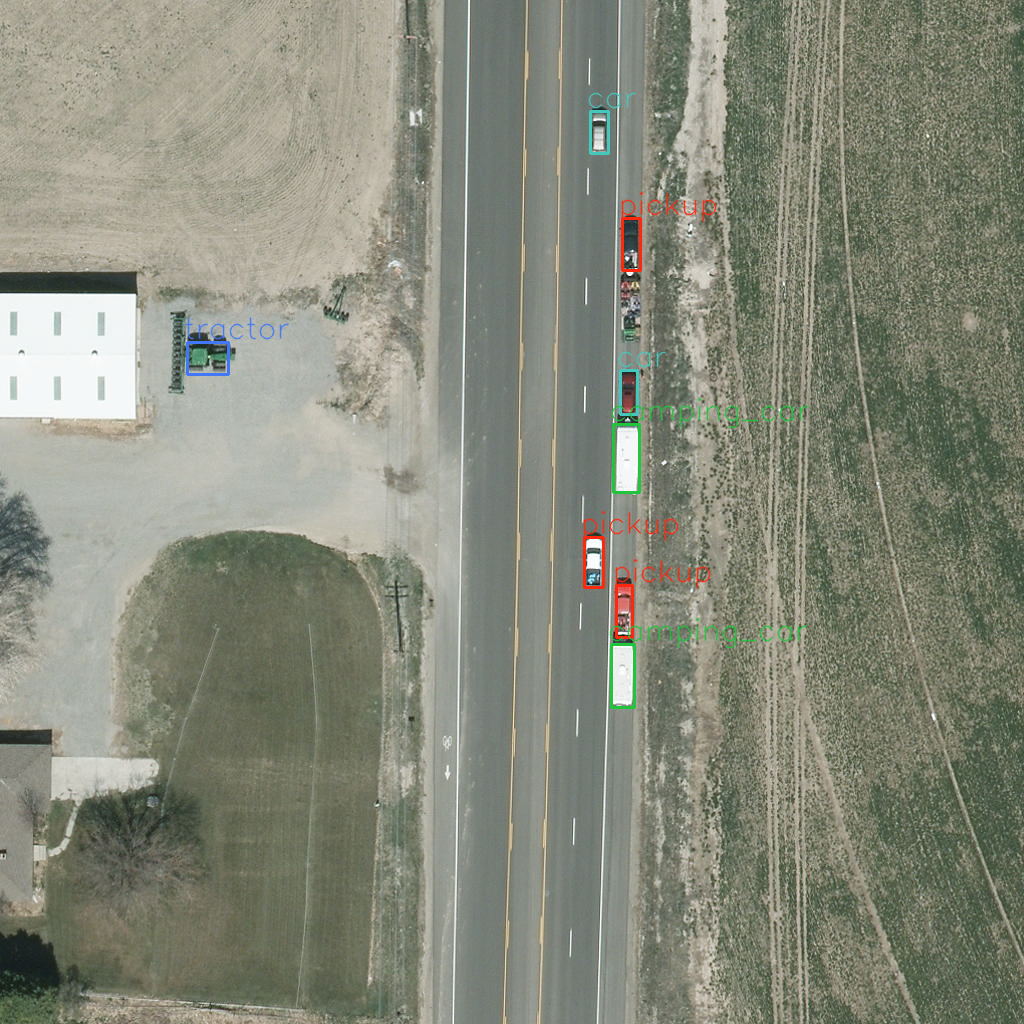

In [ ]:
display_images_and_labels("./train/00000073.png")

# tile images

In [ ]:
# Reference: https://github.com/slanj/yolo-tiling/blob/main/tile_yolo.py
# Code taken from above reference and modified to this problem

def tiler(imnames, newpath, falsepath, slice_size, ext):
    '''
    This function converts images into 
    blocks of slice_size x slice_size
    '''
    
    for imname in imnames:
        im = cv2.imread(imname)
        height, width, _ = im.shape
        h_new = math.ceil(height/slice_size) * slice_size
        w_new = math.ceil(width/slice_size) * slice_size
        im = cv2.resize(im, (w_new, h_new), cv2.INTER_LINEAR)
        labname = imname.replace(ext, '.txt')
        labels = pd.read_csv(labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
        
        # we need to rescale coordinates from 0-1 to real image height and width
        labels[['x1', 'w']] = labels[['x1', 'w']] * w_new
        labels[['y1', 'h']] = labels[['y1', 'h']] * h_new
        
        boxes = []
        
        # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
        for row in labels.iterrows():
            x1 = row[1]['x1'] - row[1]['w']/2
            y1 = (h_new - row[1]['y1']) - row[1]['h']/2
            x2 = row[1]['x1'] + row[1]['w']/2
            y2 = (h_new - row[1]['y1']) + row[1]['h']/2

            boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
        
        
        #print('Image:', imname)
        # create tiles and find intersection with bounding boxes for each tile
        for i in range((h_new // slice_size)):
            for j in range((w_new // slice_size)):
                x1 = j*slice_size
                y1 = h_new - (i*slice_size)
                x2 = ((j+1)*slice_size) - 1
                y2 = (h_new - (i+1)*slice_size) + 1

                pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
                imsaved = False
                slice_labels = []

                for box in boxes:
                    if pol.intersects(box[1]):
                        inter = pol.intersection(box[1])        
                        
                        if not imsaved:
                            sliced_im = im[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                            
                            filename = imname.split('/')[-1]
                            slice_path = newpath + "/" + filename.replace(ext, f'_{i}_{j}{ext}')                            
                            slice_labels_path = newpath + "/" + filename.replace(ext, f'_{i}_{j}.txt')                            
                            #print(slice_path)
                            sliced_im.save(slice_path)
                            imsaved = True                    
                        
                        # get smallest rectangular polygon (with sides parallel to the coordinate axes) that contains the intersection
                        new_box = inter.envelope 
                        
                        # get central point for the new bounding box 
                        centre = new_box.centroid
                        
                        # get coordinates of polygon vertices
                        x, y = new_box.exterior.coords.xy
                        
                        # get bounding box width and height normalized to slice size
                        new_width = (max(x) - min(x)) / slice_size
                        new_height = (max(y) - min(y)) / slice_size
                        
                        # we have to normalize central x and invert y for yolo format
                        new_x = (centre.coords.xy[0][0] - x1) / slice_size
                        new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                        
                        

                        slice_labels.append([box[0], new_x, new_y, new_width, new_height])
                
                if len(slice_labels) > 0:
                    slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                    #print(slice_df)
                    slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
                
                
                if not imsaved and falsepath:
                    sliced_im = im[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                    
                    filename = imname.split('/')[-1]
                    slice_path = falsepath + "/" + filename.replace(ext, f'_{i}_{j}{ext}')                

                    sliced_im.save(slice_path)
                    #print('Slice without boxes saved')
                    imsaved = True
    
    print("tiling successfully completed")

In [ ]:

ext = ".png"
size = 416

train_src = "./train/"
cv_src = "./cv/"
test_src = "./test/"


train_imnames = [train_src + name for name in os.listdir(train_src) if name.endswith(ext)]
cv_imnames = [cv_src + name for name in os.listdir(cv_src) if name.endswith(ext)]
test_imnames = [test_src + name for name in os.listdir(test_src) if name.endswith(ext)]


tiler(train_imnames, "./train_tiled/", None, size, ".png")
tiler(cv_imnames, "./cv_tiled/", None, size, ".png")
tiler(test_imnames, "./test_tiled/", None, size, ".png")

In [ ]:
# Reference: https://github.com/theAIGuysCode/YOLOv4-Cloud-Tutorial/blob/master/yolov4/generate_test.py

def generate_text_files(images_path, name):
    images = []
    for image in tqdm(os.listdir(images_path)):
        if image.endswith(".png"):
            images.append("data/" + name + "/" + image)
    df = pd.DataFrame(images)
    df.to_csv("./data/vedai/data/" + name + ".txt", index = False, header = False)

In [ ]:
generate_text_files("./train_tiled/", "train_tiled")
generate_text_files("./cv_tiled/", "cv_tiled")
generate_text_files("./test_tiled/", "test_tiled")

100%|████████████████████████████████████████████████| 656/656 [00:00<?, ?it/s]
